<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Outbreak_Detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Download the packages if not already available
packages_needed <- c("surveillance", "forecast")
packages_to_install <- packages_needed[!(packages_needed %in% installed.packages()[,"Package"])]

if(length(packages_to_install)) {
  install.packages(packages_to_install)
}
lapply(packages_needed, library, character.only = TRUE)

[[1]]
 [1] "forecast"     "surveillance" "xtable"       "sp"           "purrr"       
 [6] "readr"        "tidyr"        "dplyr"        "ggplot2"      "stats"       
[11] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[16] "base"        

[[2]]
 [1] "forecast"     "surveillance" "xtable"       "sp"           "purrr"       
 [6] "readr"        "tidyr"        "dplyr"        "ggplot2"      "stats"       
[11] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[16] "base"

In [5]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(readr)
library(purrr)

library(surveillance)  # For Farrington & EARS
library(forecast)      # For ARIMA

# Make R in Colab works with Drive
This setting allows me to replicate the "mount Google Drive" functionality from Python in Colab, since R in Colab also provides a built-in way to access Google Drive.

Ref:
https://colab.research.google.com/drive/1nXsie313OuXjIZMsSOnJULcUpwecsRB-

In [6]:
if (file.exists("/usr/local/lib/python3.6/dist-packages/google/colab/_ipython.py")) {
  install.packages("R.utils")
  library(R.utils)
  library(httr)
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
}

In [7]:
packages <- c("googledrive", "googlesheets4")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(packages, rownames(installed.packages())))
}

In [8]:
library(googledrive)
library(googlesheets4)


Attaching package: ‘googlesheets4’


The following objects are masked from ‘package:googledrive’:

    request_generate, request_make




In [9]:
# Save cache in a file so that i don't have to authenticate repeatedly
drive_auth(cache = "/content/drive/My Drive/.secrets", use_oob = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=8d0ae9d48213da57a49b9f6d00e0472e&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVVKUi14NkFDVGwzQkk4VGtpSmY1TW5sRU1TY00tcHRtMW0yeG1fV1UyZzRvLXFONVFMTi1VNERlYUwxblZwQTJCWVJtZyIsInN0YXRlIjoiOGQwYWU5ZDQ4MjEzZGE1N2E0OWI5ZjZkMDBlMDQ3MmUifQ==


# Read Data

In [12]:
path <- "simulation_data(grid-2000 days).csv"
drive_download(file = paste0("simulation/", path), path = path, overwrite = TRUE)

data <- read_csv(path)
data <- data %>% rename(True_Outbreak = "True Outbreak")
data <- data %>% rename(Reported_Cases = "Reported Cases")
data$Population <- data$Susceptible + data$Infected + data$Recovered
data$Region <- data$Region + 1 #Convert from (0 - 2) to (1 - 3) due to R indexing
tail(data)

File downloaded:

• simulation_data(grid-2000 days).csv <id: 1-524jCvNNs4fwHdaBiSlx6ZUbSfXPQvq>

Saved locally as:

• simulation_data(grid-2000 days).csv

Rows: 50000 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): Day, Region, Susceptible, Infected, Recovered, Reported Cases, True...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Day,Region,Susceptible,Infected,Recovered,Reported_Cases,True_Outbreak,Population
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1994,25,372,169,455,22,1,996
1995,25,371,166,434,4,1,971
1996,25,344,173,434,14,1,951
1997,25,335,169,444,7,1,948
1998,25,353,177,429,9,1,959
1999,25,350,167,444,5,1,961


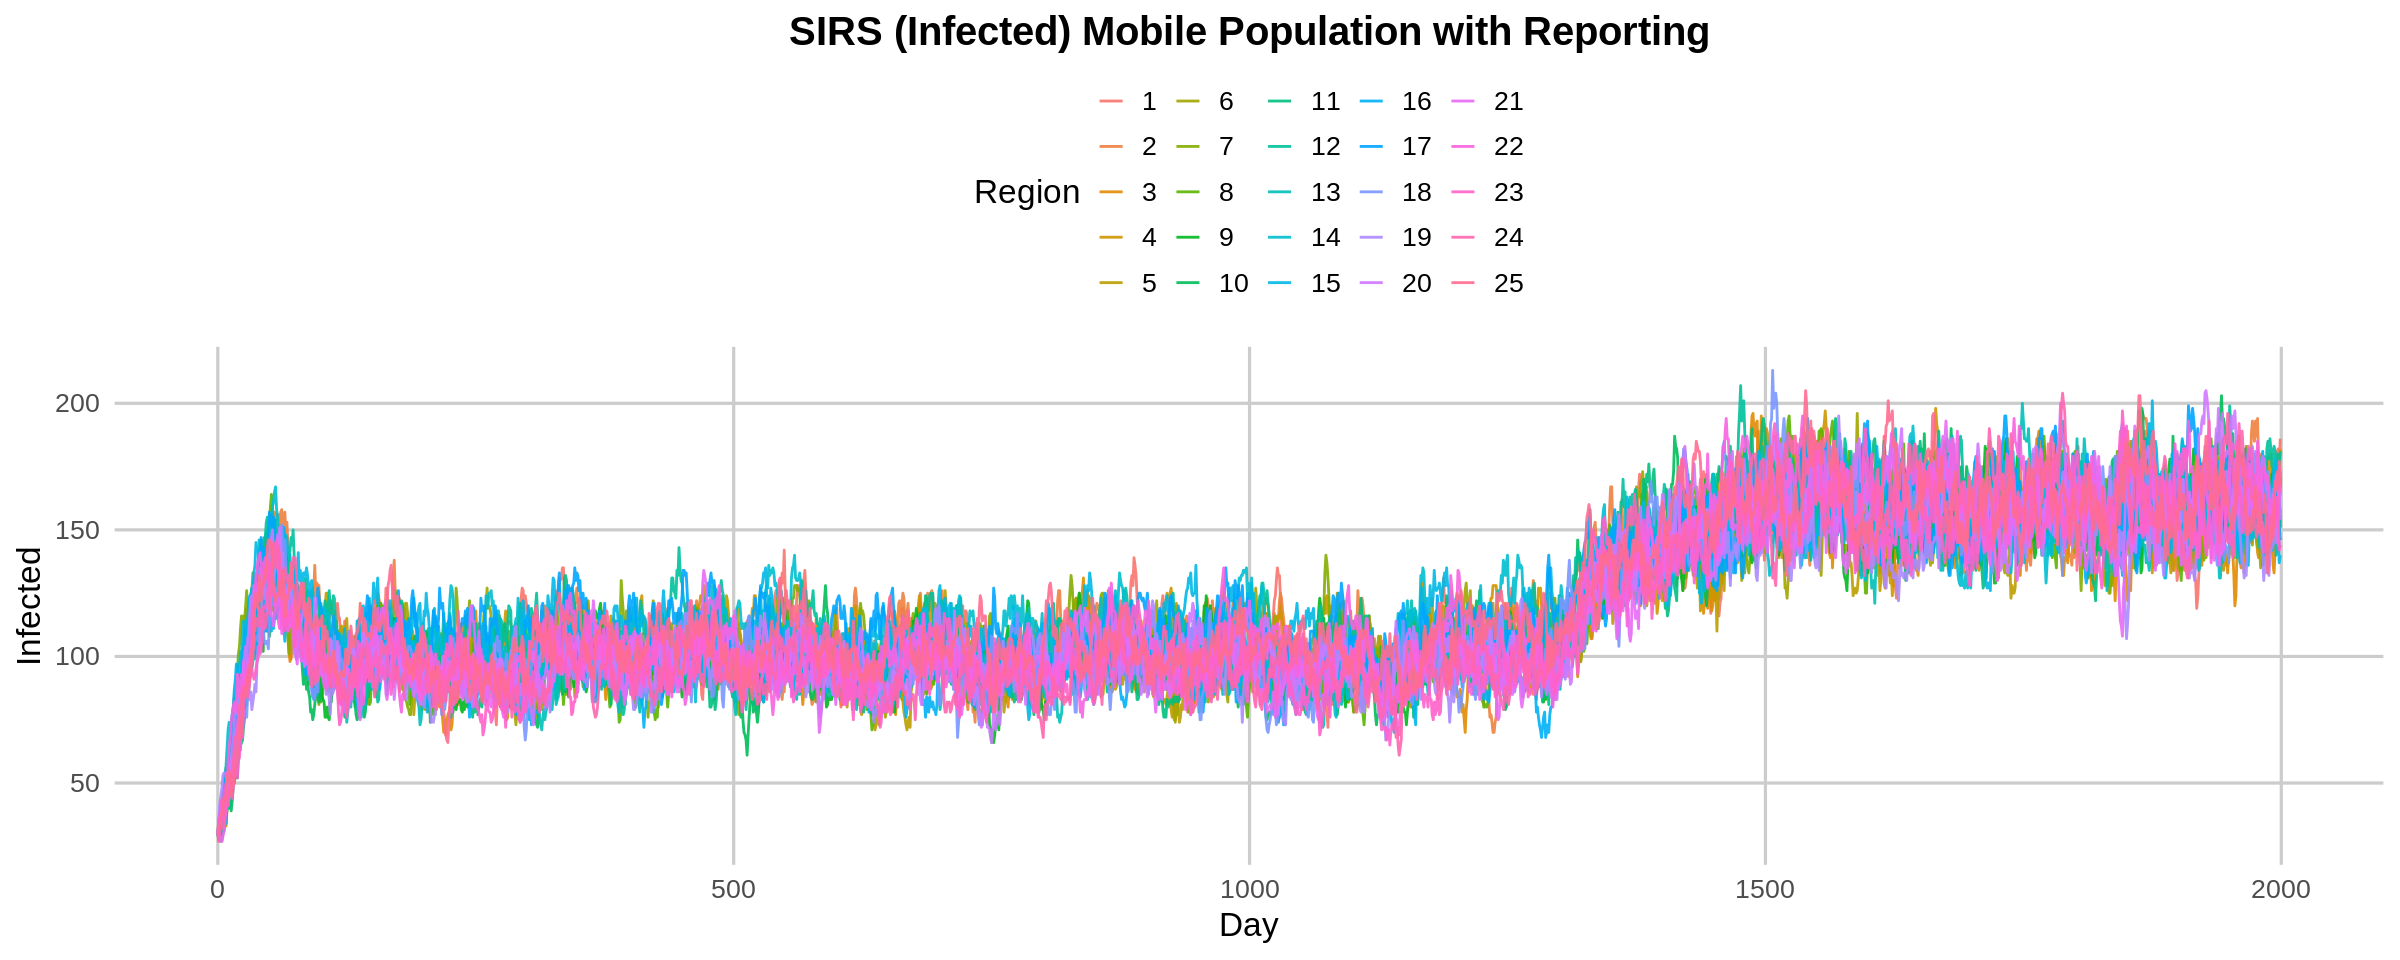

In [23]:
# PLot to determine the inital period that I want to discard
options(repr.plot.width = 20, repr.plot.height = 8)
ggplot(data, aes(x = Day, y = Infected, color = factor(Region))) +
  geom_line(size = 0.8, alpha = 0.9) +
  labs(
    title = "SIRS (Infected) Mobile Population with Reporting",
    x     = "Day",
    y     = "Infected",
    color = "Region"
  ) +
  theme_minimal(base_size = 20) +
  theme(
    panel.grid.major  = element_line(color = "grey80"),
    panel.grid.minor  = element_blank(),
    plot.title        = element_text(face = "bold", hjust = 0.5),
    legend.position   = "top"
  )


In [24]:
burn_in <- 250 # Discard the initial 250 days
data_processed <- data %>% filter(Day > burn_in) # "data_processed" is the name of dataset that i will use to process from now-n

# Summarise when the outbreak starts and end (mostly for plotting purposes)
outbreak_periods <- data_processed %>%
  arrange(Day) %>%
  mutate(
    start_flag = (True_Outbreak == 1) & (lag(True_Outbreak, default = 0) == 0), # Start day must be when the day now has label 1 and yesterday 0
    end_flag   = (True_Outbreak == 0) & (lag(True_Outbreak, default = 1) == 1)  # End day must be when the day now has label 0 and yesterday 1
  ) %>%
  mutate(group = cumsum(start_flag)) %>%
  filter(True_Outbreak == 1) %>%
  group_by(group) %>%
  summarise(
    start = min(Day),
    end   = max(Day)
  )

In [36]:
## Aggregate to "world level"
t1 <- 1270
data_world <- data_processed %>%
  group_by(Day) %>%
  summarise(Reported_Cases = sum(Reported_Cases), .groups = "drop") %>%
  # Label days starting from t1 as outbreak period
  mutate(True_Outbreak = as.integer(Day >= t1))


outbreak_world <- outbreak_periods %>%
  distinct(start, end)

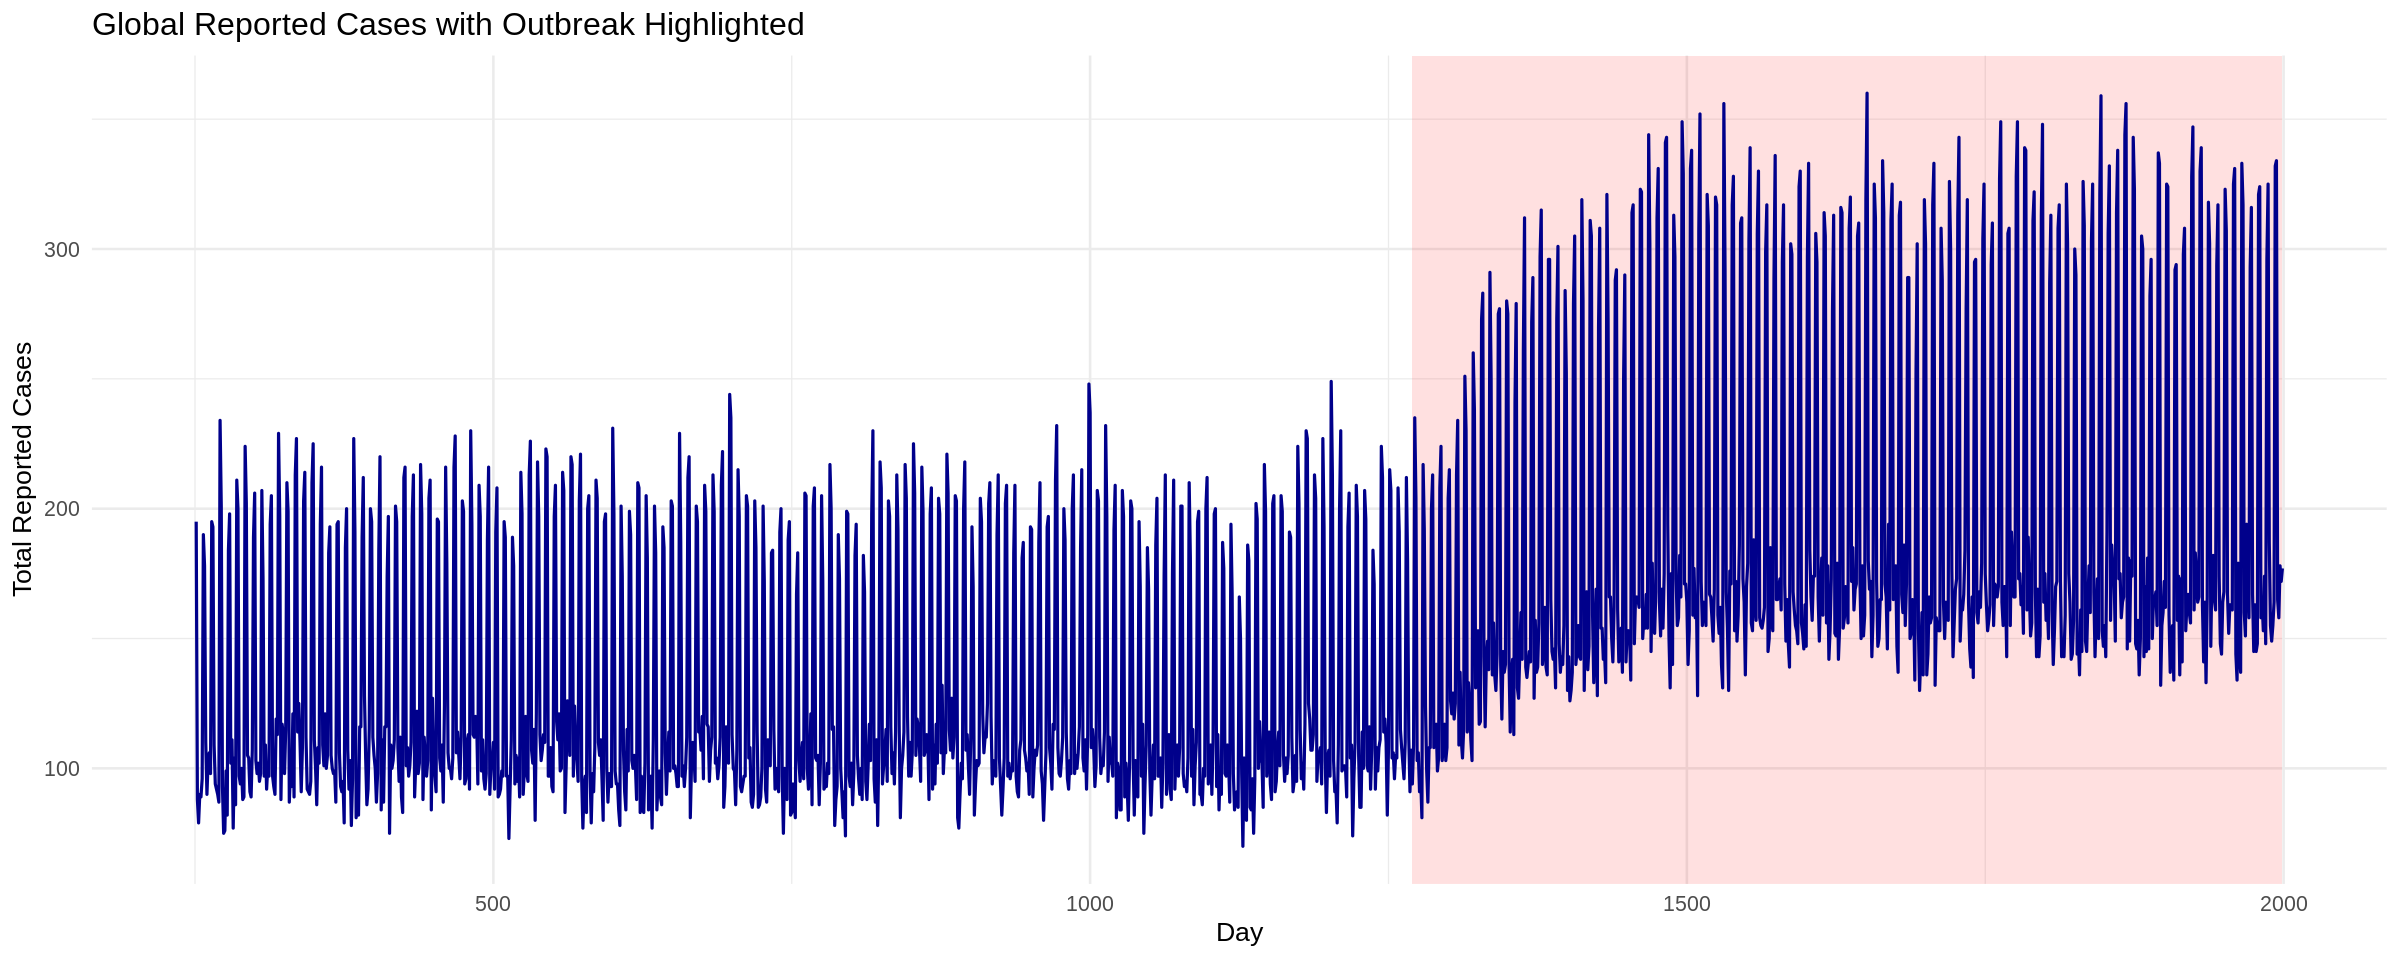

In [38]:
ggplot(data_world, aes(x = Day, y = Reported_Cases)) +
  geom_rect(
    data = outbreak_world,
    aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
    fill = "red", alpha = 0.12, inherit.aes = FALSE
  ) +
  geom_line(color = "darkblue", size = 0.9) +
  labs(
    title = "Global Reported Cases with Outbreak Highlighted",
    x = "Day",
    y = "Total Reported Cases"
  ) +
  theme_minimal(base_size = 16)


# **Detection**

In [39]:
# Flexible Farrington detection
detect_farrington_flex <- function(df, b = 1, w = 2, noPeriods = 1, pastWeeksNotIncluded = 0, trend = FALSE) {

  # Aggregate to weekly because farrington flexible is available only weekly
  df_week <- df %>%
    mutate(Week = floor((Day - min(Day))/7) + 1) %>%
    group_by(Week) %>%
    summarise(
      Reported_Cases = sum(Reported_Cases)
    )

  # Create the sts object (because it is required the input to be sts object) and run farrington flexible
  sts_week <- sts(observed = df_week$Reported_Cases, freq = 1)
  farr_week <- farringtonFlexible(
    sts_week,
    control = list(
      b = b, w = w, noPeriods = noPeriods,
      pastWeeksNotIncluded = pastWeeksNotIncluded,
      trend = trend,
      alpha = 0.05
    )
  )
  # Convert alarms to 0(no outbreak)/1(outbreak)
  farr_week_signal <- as.numeric(alarms(farr_week) > 0)
  # Convert weekly to daily
  farr_signal_daily <- rep(farr_week_signal, each = 7)

  return(farr_signal_daily)
}

In [40]:
# EARS detection
detect_ears <- function(df, method = "C3", baseline = 63) {
  # Convert to sts object
  sts_cases <- sts(observed = df$Reported_Cases, freq = 1)
  # EARS with the method can be C1/C2/C3 and baseline is the temporal window
  ears <- earsC(sts_cases, control = list(method = method, baseline = baseline))
  # Convert alarms to 0(no outbreak)/1(outbreak)
  ears_signal <- as.numeric(alarms(ears) > 0)
  return(ears_signal)
}


In [31]:
# ARIMA detection
detect_arima <- function(df, window_size = 250, interval = 0.95, jump = 14) {
  # Parameters:
  # df = input data
  # window_size = window size for training (i.e. n_days for training)
  # interval =  confidence interval for the upper bound (e.g., 0.95 for 95%).
  # jump = number of days to jump the window (here i picked 14 just as example case)

  n <- nrow(df) # Take the number of datapoints (duration)
  arima_signal <- rep(0, n) # Initialize alarm signal
  t <- window_size + 1 # Start prediction at window_size + 1
  while (t <= n) {
    start_day <- max(1, t - window_size)
    train_data <- df$Reported_Cases[start_day:(t-1)]  # Train data is from the start day until t, i.e. the size of the window
    arima_fit <- auto.arima(train_data) # Fit automatically to determine the best coefficient
    # Determine how many days to forecast ahead:
    # Use the lesser value of 'jump' or the number of days remaining in the data (including the current day).
    h <- min(jump, n - t + 1)
    preds <- forecast(arima_fit, h = h, level = interval * 100)
    uppers <- preds$upper[, 1] #Take the upper bound of the prediction interval as the outbreak threshold

    # Check for alarms
    for (j in 0:(h - 1)) {
      tt <- t + j # Use tt for day indexing
      if (tt > n) break
      # If the number of reported cases is bigger than the threshold, then raise the alarm (labeled as 1)
      if (df$Reported_Cases[tt] > uppers[j + 1]) {
        arima_signal[tt] <- 1
      }
    }
    t <- t + jump # To jump the window for the next batch
  }
  # Keep only post-burn-in days, in other words exclude the 1st batch training days
  arima_without_burn <- arima_signal[(window_size + 1):n]
  return(arima_without_burn)
}


In [32]:
metrics <- function(true, detected) {
  # This function calculates the evalutation metrics Sensitivity, Specificity, Precision
  TP <- sum(true == 1 & detected == 1)
  FP <- sum(true == 0 & detected == 1)
  TN <- sum(true == 0 & detected == 0)
  FN <- sum(true == 1 & detected == 0)
  Sensitivity <- ifelse((TP+FN)==0, NA, TP/(TP+FN))
  Specificity <- ifelse((TN+FP)==0, NA, TN/(TN+FP))
  Precision   <- ifelse((TP+FP)==0, NA, TP/(TP+FP))
  list(Sensitivity=Sensitivity, Specificity=Specificity, Precision=Precision)
}

In [33]:
analyze_region <- function(df, true_label_col = "True_Outbreak", detectors, region_id = NULL) {
# This function runs the input data through all specified outbreak detection methods,
# then calculates the evaluation metrics and outputs both the detection signals and their corresponding metrics.

  # Run all detectors, collect signals as a named list
  signals_list <- lapply(detectors, function(f) f(df))
  names(signals_list) <- names(detectors)

  # Not all the detectors give the same signal length.
  # Therefore, find the minimum length to align all signals and labels
  true_label <- df[[true_label_col]]
  all_lengths <- c(length(true_label), sapply(signals_list, length))
  min_len <- min(all_lengths)

  # and trim everything
  true_label_cut <- tail(true_label, min_len)
  signals_cut <- lapply(signals_list, tail, min_len)

  # Compute metrics for each method, using the trimmed signal
  metrics_list <- mapply(function(method, signal) {
    m <- metrics(true_label_cut, signal)
    tibble::tibble(
      Region = region_id,
      Method = method,
      Sensitivity = m$Sensitivity,
      Specificity = m$Specificity,
      Precision = m$Precision,
    )
  }, method = names(signals_cut), signal = signals_cut, SIMPLIFY = FALSE)

  metrics_df <- dplyr::bind_rows(metrics_list)

  # Make metrics and aligned signals as output
  signals_df <- data.frame(Day = tail(df$Day, min_len),
                           True.Label = true_label_cut,
                           signals_cut)

  return(list(metrics = metrics_df, signals = signals_df))
}


In [34]:
detectors <- list(
  Farrington_Flexible = detect_farrington_flex,
  EARS = detect_ears,
  ARIMA = detect_arima
)

In [35]:
# region_ids <- unique(data_processed$Region)
# region_list <- lapply(region_ids, function(id) {
#   data_processed %>% filter(Region == id) %>% arrange(Day)
# })

# all_results <- mapply(function(df, id) {
#   analyze_region(df, true_label_col = "True_Outbreak", detectors, region_id = id)
# }, df = region_list, id = region_ids, SIMPLIFY = FALSE)

# # Combine metrics for all regions
# metrics_all <- do.call(rbind, lapply(all_results, `[[`, "metrics"))
# metrics_all

# Apply detection analysis on the global data
global_result <- analyze_region(data_world, true_label_col = "True_Outbreak", detectors, region_id = "Global")

# View metrics
global_result$metrics

Region,Method,Sensitivity,Specificity,Precision
<chr>,<chr>,<lgl>,<lgl>,<lgl>
Global,Farrington_Flexible,NA,NA,NA
Global,EARS,NA,NA,NA
Global,ARIMA,NA,NA,NA


Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_rect()`).”


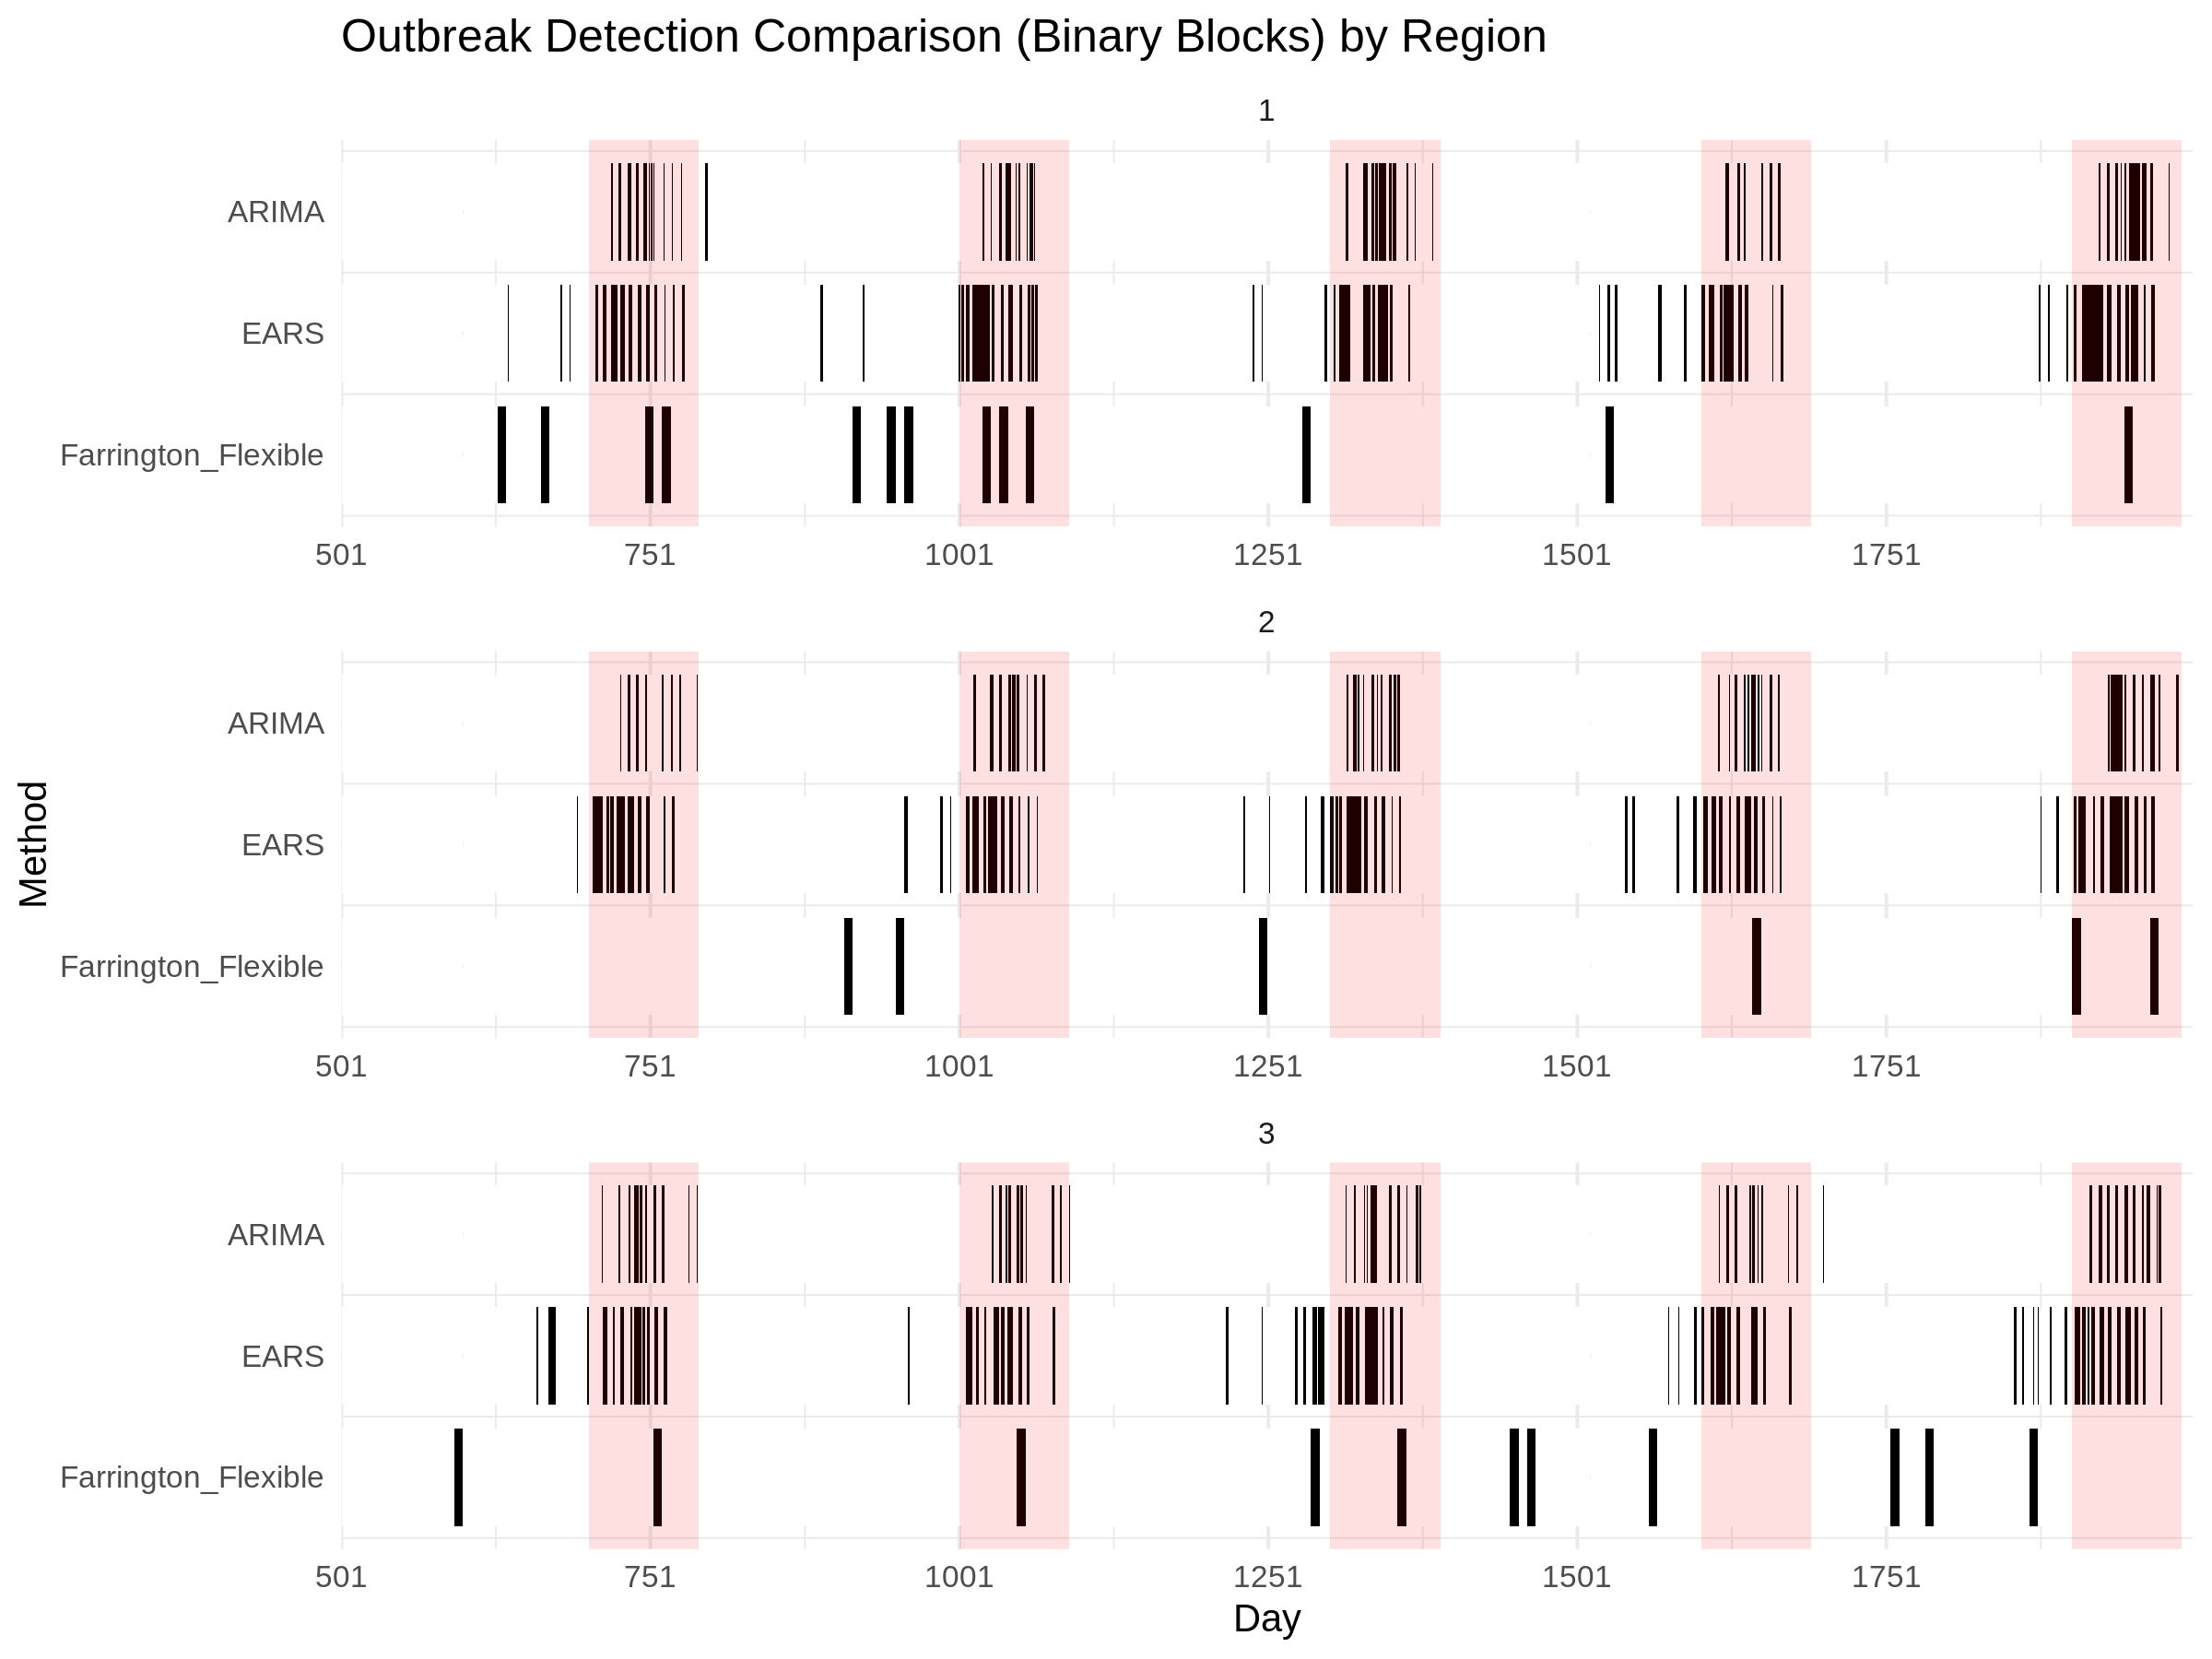

In [ ]:
 # Take the signal output from the detection results
signals_long <- map2_dfr(all_results, region_ids, ~
  .x$signals %>%
    pivot_longer(
      cols       = all_of(names(detectors)),
      names_to   = "Method",
      values_to  = "Detected"
    ) %>%
    mutate(Region = .y)
)

# Take the first days according to signal
# This is because I want the date that I plot starts where the output from the detection are taken for evaluation
first_days <- map_int(all_results, ~ first(.x$signals$Day))
start_day  <- min(first_days, na.rm = TRUE)


# Plotting variabless
method_levels <- names(detectors)
signals_long <- signals_long %>%
  mutate(
    Method = factor(Method, levels = method_levels),
    BlockY = as.integer(Method)
  )

plot_start <- start_day
plot_end   <- max(signals_long$Day, na.rm = TRUE)

# Ensure start_day is in the breaks
x_ticks <- unique(c(plot_start, seq(plot_start, plot_end, by = 250)))
options(repr.plot.width = 20, repr.plot.height = 15)
ggplot(signals_long, aes(x = Day, y = BlockY, fill = factor(Detected))) +
  geom_tile(height = 0.8, width = 1, show.legend = FALSE) +
  geom_rect(
    data        = outbreak_periods,
    inherit.aes = FALSE,
    aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
    fill        = "red", alpha = 0.12
  ) +
  facet_wrap(~ Region, ncol = 1, scales = "free_x") +
  scale_x_continuous(
    limits = c(plot_start, plot_end),
    breaks = x_ticks,
    expand = c(0, 0)
  ) +
  scale_y_continuous(
    breaks = seq_along(method_levels),
    labels = method_levels,
    expand = c(0.05, 0.05)
  ) +
  scale_fill_manual(values = c("0" = "white", "1" = "black")) +
  labs(
    title = "Outbreak Detection Comparison (Binary Blocks) by Region",
    x     = "Day",
    y     = "Method"
  ) +
  theme_minimal(base_size = 25)
